도로명주소를 x,y좌표로 변환하는 코드는 R코드로 따로 첨부합니다.

# 하버사인 거리 구하기

In [ ]:
from haversine import haversine, Unit
import json
import requests

api_key = "84500547d46e87dcc8d6c3937fb3a35b"

In [ ]:
#두 위경도 좌표값을 파라미터로 받아 두 점 사이의 하버사인 거리를 계산하는 함수 hdistance
def hdistance(myloc, testloc):
    try:
        distance = haversine(myloc, testloc)
        return distance
    except:
        return None

In [ ]:
#string으로 저장되어 있는 튜플을 튜플로 변환해주는 함수 strtotuple
def strtotuple(input):
    c = input.split()
    a = float(c[0][1:-1])
    b = float(c[1][0:-1])
    c = (a, b)
    return c

In [ ]:
좌표=[]
for x,y in zip(data.위도, data.경도):
  좌표.append('('+str(x)+', '+str(y)+')')

In [ ]:
from collections import defaultdict
pre_df=defaultdict(list)

for i in range(len(data)):
  temp=[]
  u_temp=strtotuple(data.loc[i].좌표)

  for cd in coor.좌표:
    temp.append(haversine(strtotuple(cd),u_temp))

  pre_df[data.역명[i]]=temp

pre_df=pd.DataFrame(pre_df)

# 설명변수 생성, 데이터프레임 구성

In [ ]:
#2키로 이하 거리의 지하철 개수
df_bool=(pre_df<=2)  # <---5 대신 다른 숫자 가능
metro_in2=df_bool.sum(axis=1)

In [ ]:
#가장 가까운 지하철까지의 거리
closest_metro_d=pre_df.min(axis=1)

In [ ]:
#가장 가까운 지하철 이름
closest_metro=pre_df.idxmin(axis=1)

In [ ]:
pre_df['metro_in2']=metro_in2
pre_df['closest_metro_d']=closest_metro_d
pre_df['closest_metro']=closest_metro

In [ ]:
df=pd.concat([coor,pre_df], axis=1) #전처리한 설명변수와 기존 input 좌표를 병합한다.

EDA 코드는 R코드로 따로 첨부합니다.

# 군집분석

In [ ]:
df.columns

In [ ]:
feature_names=['univ_d', 'univ_5', 'closest_bank_d', 'bank_in2', 'closest_fa_d',
       'fa_in2', 'closest_fa2_d', 'fa2_in2', 'closest_market_d', 'market_in3', 'closest_metro_d',
       'metro_in2', 'closest_bus_d', 'bus_in2','closest_culture_d', 'culture_in2',
       'closest_cafe_d','cafe_in2','closest_conv_d',
       'conv_in1']
data=df[feature_names]

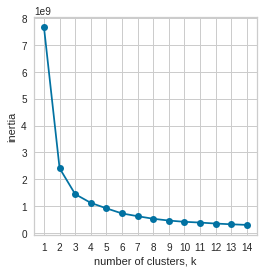

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# 적절한 군집수 찾기
# Inertia(군집 내 거리제곱합의 합) value (적정 군집수)

ks = range(1,15)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(data)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

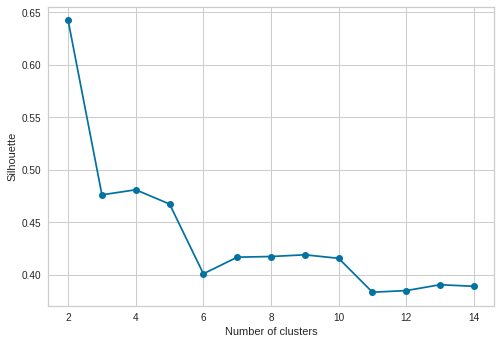

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_samples
#실루엣계수
silhouette_vals=[]
for i in range(2,15):
  kmeans_plus=KMeans(n_clusters=i,init='k-means++')
  pred=kmeans_plus.fit_predict(data)
  silhouette_vals.append(np.mean(silhouette_samples(data,pred,metric='euclidean')))

plt.plot(range(2,15),silhouette_vals, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')
plt.show()

In [ ]:
from sklearn.cluster import SpectralClustering

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score

def visualize_silhouette(cluster_lists, X_features,a): 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    for ind, n_cluster in enumerate(cluster_lists):
        clusterer = KMeans(n_clusters = n_cluster                                          
                     , n_init=10 
                     , max_iter=50 
                     , random_state = 42) 
               
        cluster_labels = clusterer.fit_predict(X_features)
        colors = plt.cm.tab10(np.arange(20, dtype=int))
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel(a)
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

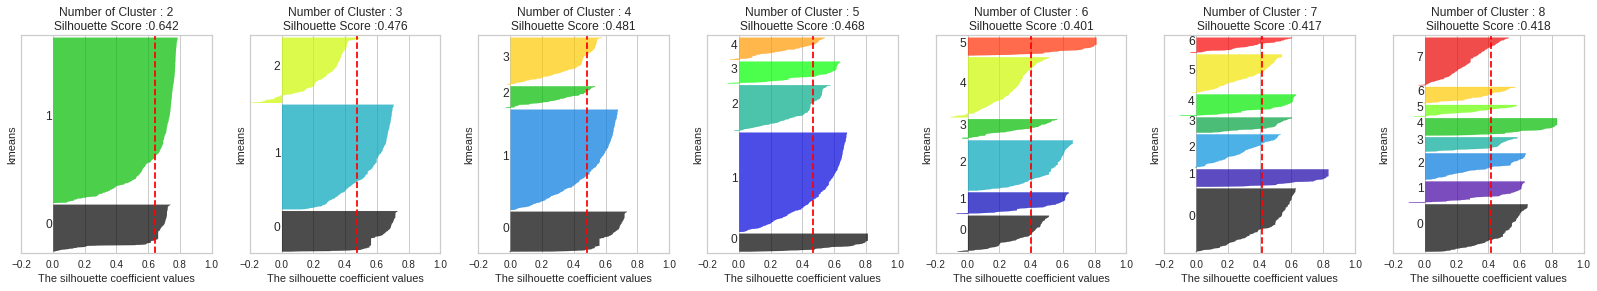

In [ ]:
visualize_silhouette([2,3,4,5,6,7,8], data,'kmeans')

In [ ]:
# K-Means 모델과 군집 예측값을 생성 
# 클러스터 모델 생성 파라미터는 원할 경우 추가 
from sklearn.cluster import KMeans
clust_model = KMeans(n_clusters = 7 # 클러스터 개수                                         
                     , n_init=10 # initial centroid를 몇번 샘플링한건지, 데이터가 많으면 많이 돌릴수록안정화된 결과가 나옴 
                     , max_iter=50 # KMeans를 몇번 반복 수행할건지, K가 큰 경우 1000정도로 높여준다 
                     , random_state = 42) 
# 생성한 모델로 데이터를 학습시킴 
clust_model.fit(data) 

# 결과 값을 변수에 저장 
centers = clust_model.cluster_centers_ # 각 군집의 중심점 
pred = clust_model.predict(data) # 각 예측군집 
print(pd.DataFrame(centers)) 
print(pred[:10])

         0          1         2           3         4            5         6   \
0  2.656174   4.309589  0.247692   33.843836  0.107897   825.780822  0.155409   
1  1.645284  12.396040  0.053530  284.207921  0.020576  4308.514851  0.034102   
2  2.371274   3.380208  0.164850   77.718750  0.118504  1038.411458  0.168309   
3  2.719036   8.250000  0.144273   87.318182  0.042416  3341.386364  0.050714   
4  1.189179  14.162602  0.072462  224.447154  0.027299  5802.398374  0.030706   
5  2.017293   8.425339  0.189177   75.389140  0.045321  1936.728507  0.055090   
6  2.064887   4.885057  0.128923  133.873563  0.063891  1544.574713  0.068101   

            7         8          9         10         11        12  \
0   694.715068  0.467683  24.717808  0.520918   5.926027  0.116147   
1  4429.742574  0.100664  69.336634  0.173727  16.722772  0.119372   
2  1379.479167  0.377880  39.791667  0.450600   8.625000  0.123641   
3  2226.625000  0.246763  60.886364  0.413647  10.579545  0.092736   
4

In [ ]:
# 원래 데이터에 예측된 군집 붙이기 
clust_df = data.copy() 
clust_df['clust'] = pred 
clust_df.head()

,univ_d,univ_5,closest_bank_d,bank_in2,closest_fa_d,fa_in2,closest_fa2_d,fa2_in2,closest_market_d,market_in3,...,metro_in2,closest_bus_d,bus_in2,closest_culture_d,culture_in2,closest_cafe_d,cafe_in2,closest_conv_d,conv_in1,clust
0,3.411956,2,0.334973,52,0.064169,610,0.048128,1285,1.031082,20,...,4,0.035626,133,0.061417,58,0.060401,1165,0.126768,31,0
1,5.022489,0,0.214925,69,0.083160,494,0.083160,833,0.432403,42,...,12,0.273543,116,0.447655,66,0.147974,1425,0.147974,15,0
2,5.022489,0,0.214925,69,0.083160,494,0.083160,833,0.432403,42,...,12,0.273543,116,0.447655,66,0.147974,1425,0.147974,15,0
3,5.179168,0,0.101144,56,0.174375,467,0.243207,759,0.163175,41,...,10,0.112477,116,0.450584,56,0.082927,1249,0.082927,13,0
4,3.953104,1,0.455393,79,0.116755,544,0.278396,1194,0.516564,28,...,9,0.133694,163,0.537988,68,0.110775,1562,0.245451,18,0


In [ ]:
clust_df['clust'].value_counts() 

0    365
5    221
2    192
4    123
1    101
3     88
6     87
Name: clust, dtype: int64

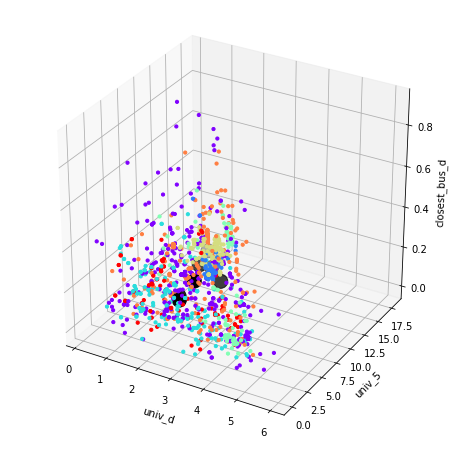

In [ ]:
# 3차원으로 시각화하기
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
X = clust_df

# 데이터 scatterplot 
ax.scatter( X.iloc[:,0] , X.iloc[:,1] , X.iloc[:,2] , c = X.clust , s = 10 , cmap = "rainbow" , alpha = 1 )

# centroid scatterplot 
ax.scatter(centers[:,0],centers[:,1],centers[:,2] ,c='black', s=200)

ax.set_xlabel(data.columns[0] )
ax.set_ylabel(data.columns[1] )
ax.set_zlabel(data.columns[12] )

plt.show()

In [ ]:
a=clust_df['clust']

In [ ]:
b=df['좌표']

In [ ]:
df=pd.concat([b,a], axis=1)

In [ ]:
df

,좌표,clust
0,"(37.4753216045886, 127.050395378069)",0
1,"(37.4956264931259, 127.077191033018)",0
2,"(37.4956264931259, 127.077191033018)",0
3,"(37.4942045850869, 127.077648338611)",0
4,"(37.4883239313325, 127.061169470744)",0
...,...,...
1172,"(37.6158126968346, 127.093737926072)",0
1173,"(37.6035511005784, 127.083719618544)",5
1174,"(37.5977779830078, 127.079849262729)",5
1175,"(37.6050067642661, 127.077620560192)",5


In [ ]:
# 칼럼 두개로 쪼개기-구분자',' 를 기준으로 n개로 나눈다, expand=True이면 여러 컬럼, False이면 1개 컬럼에 리스트
df[['latitude', 'longitude']] = df['좌표'].str.split(",", n=1, expand=True)

In [ ]:
df

,좌표,clust,latitude,longitude
0,"(37.4753216045886, 127.050395378069)",0,(37.4753216045886,127.050395378069)
1,"(37.4956264931259, 127.077191033018)",0,(37.4956264931259,127.077191033018)
2,"(37.4956264931259, 127.077191033018)",0,(37.4956264931259,127.077191033018)
3,"(37.4942045850869, 127.077648338611)",0,(37.4942045850869,127.077648338611)
4,"(37.4883239313325, 127.061169470744)",0,(37.4883239313325,127.061169470744)
...,...,...,...,...
1172,"(37.6158126968346, 127.093737926072)",0,(37.6158126968346,127.093737926072)
1173,"(37.6035511005784, 127.083719618544)",5,(37.6035511005784,127.083719618544)
1174,"(37.5977779830078, 127.079849262729)",5,(37.5977779830078,127.079849262729)
1175,"(37.6050067642661, 127.077620560192)",5,(37.6050067642661,127.077620560192)


In [ ]:
import re

def clean_text(inputString):
  text_rmv = re.sub('[-=+,#/\?:^@*\"※~ㆍ!』 〔‘|\(\)\[\]`\'…》\”\“\’·]', ' ', inputString)
  return text_rmv

In [ ]:
for i in range (len(df)):
  df.loc[i,"latitude"] = clean_text(df.loc[i, "latitude"])
  df.loc[i,"longitude"] = clean_text(df.loc[i, "longitude"])

In [ ]:
df

,좌표,clust,latitude,longitude
0,"(37.4753216045886, 127.050395378069)",0,37.4753216045886,127.050395378069
1,"(37.4956264931259, 127.077191033018)",0,37.4956264931259,127.077191033018
2,"(37.4956264931259, 127.077191033018)",0,37.4956264931259,127.077191033018
3,"(37.4942045850869, 127.077648338611)",0,37.4942045850869,127.077648338611
4,"(37.4883239313325, 127.061169470744)",0,37.4883239313325,127.061169470744
...,...,...,...,...
1172,"(37.6158126968346, 127.093737926072)",0,37.6158126968346,127.093737926072
1173,"(37.6035511005784, 127.083719618544)",5,37.6035511005784,127.083719618544
1174,"(37.5977779830078, 127.079849262729)",5,37.5977779830078,127.079849262729
1175,"(37.6050067642661, 127.077620560192)",5,37.6050067642661,127.077620560192


In [ ]:
df[['latitude', 'longitude']] =df[['latitude', 'longitude']].apply(pd.to_numeric)

# 시각화

In [ ]:
#여기서부터 지도 시각화
import pandas as pd
import folium as g
from folium import Marker, Icon
import requests
import json
import numpy as np

In [ ]:
m = g.Map(location=[37.55, 127.0], tiles='openstreetmap', zoom_start=10)

In [ ]:
#지도에 시각화
for i in range(len(df)):
    try:
        lasta = df['latitude'][i]
        lastb = df['longitude'][i]
        
        if df['clust'][i]==0:
            g.Marker([lasta,lastb],popup='showadd',tooltip = "0", icon=g.Icon(color='red',icon='red')).add_to(m)
        elif df['clust'][i]==1:
            g.Marker([lasta,lastb],popup='showadd',tooltip = "1", icon=g.Icon(color='pink',icon='pink')).add_to(m)
        elif df['clust'][i]==2:
            g.Marker([lasta,lastb],popup='showadd',tooltip = "2", icon = g.Icon(color='white',icon='white')).add_to(m)
        elif df['clust'][i]==3:
            g.Marker([lasta,lastb],popup='showadd',tooltip = "3", icon=g.Icon(color='lightgreen',icon='lightgreen')).add_to(m)
        elif df['clust'][i]==4:
            g.Marker([lasta,lastb],popup='showadd',tooltip = "4", icon=g.Icon(color='darkblue',icon='darkblue')).add_to(m)
        elif df['clust'][i]==5:
            g.Marker([lasta,lastb],popup='showadd',tooltip = "5", icon=g.Icon(color='gray',icon='gray')).add_to(m)
        elif df['clust'][i]==6:
            g.Marker([lasta,lastb],popup='showadd',tooltip = "6", icon=g.Icon(color='orange',icon='orange')).add_to(m)
    except KeyError:
        pass

In [ ]:
m

In [ ]:
c0=clust_df[clust_df['clust']==0]
c1=clust_df[clust_df['clust']==1]
c2=clust_df[clust_df['clust']==2]
c3=clust_df[clust_df['clust']==3]
c4=clust_df[clust_df['clust']==4]
c5=clust_df[clust_df['clust']==5]
c6=clust_df[clust_df['clust']==6]

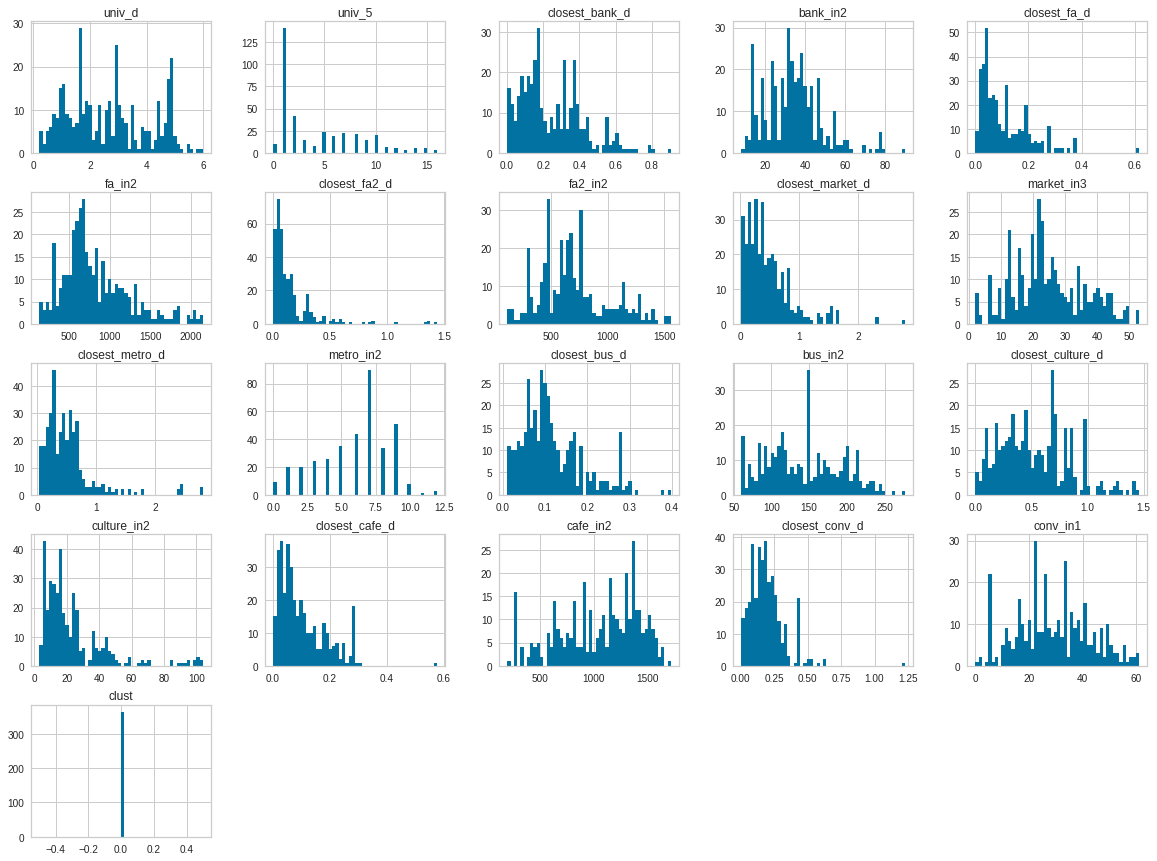

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
c0.hist(bins=50, figsize=(20,15))
plt.show()

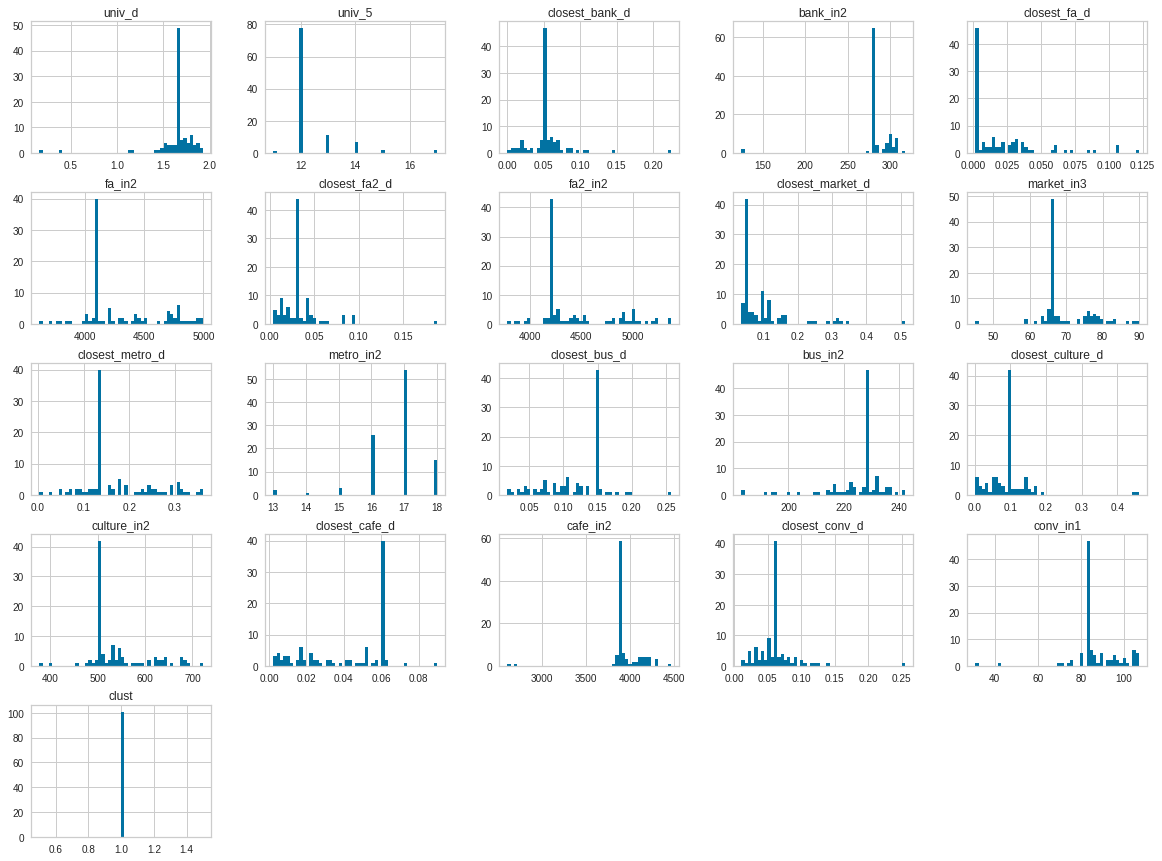

In [ ]:
c1.hist(bins=50, figsize=(20,15))
plt.show()

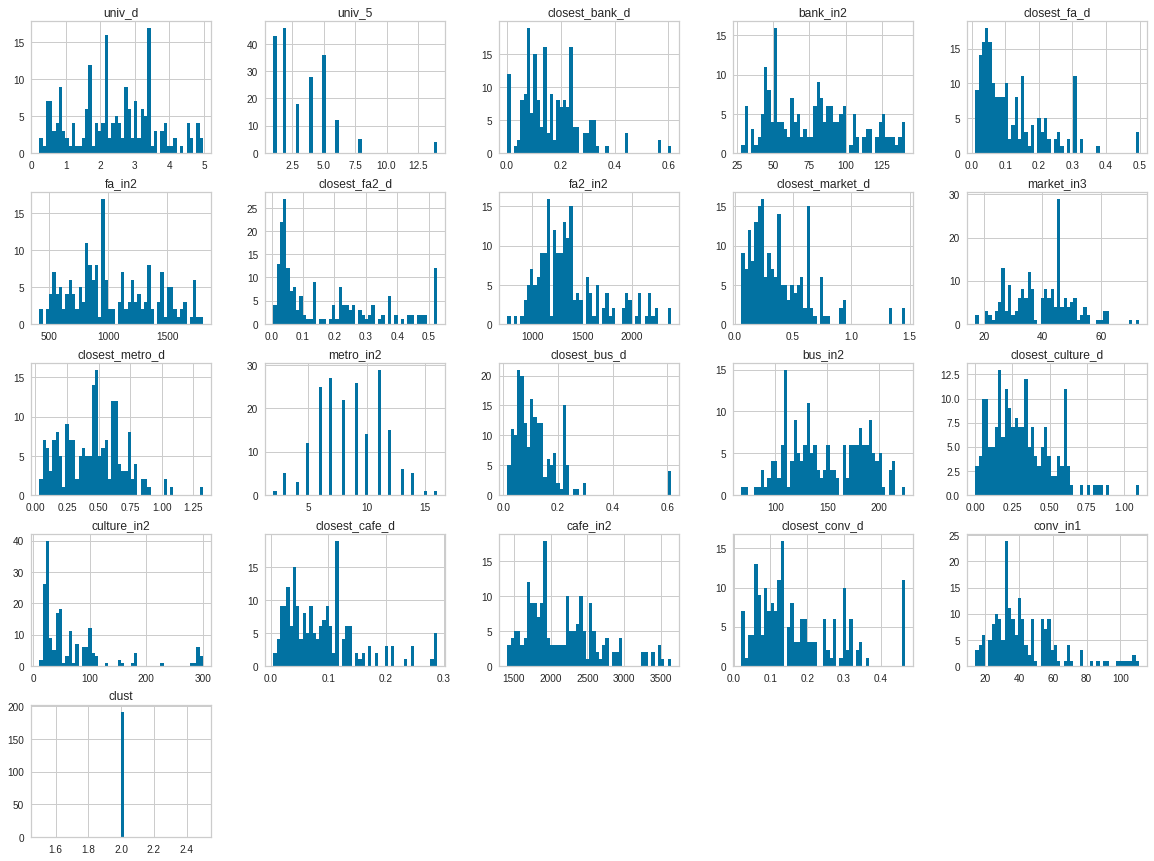

In [ ]:
c2.hist(bins=50, figsize=(20,15))
plt.show()

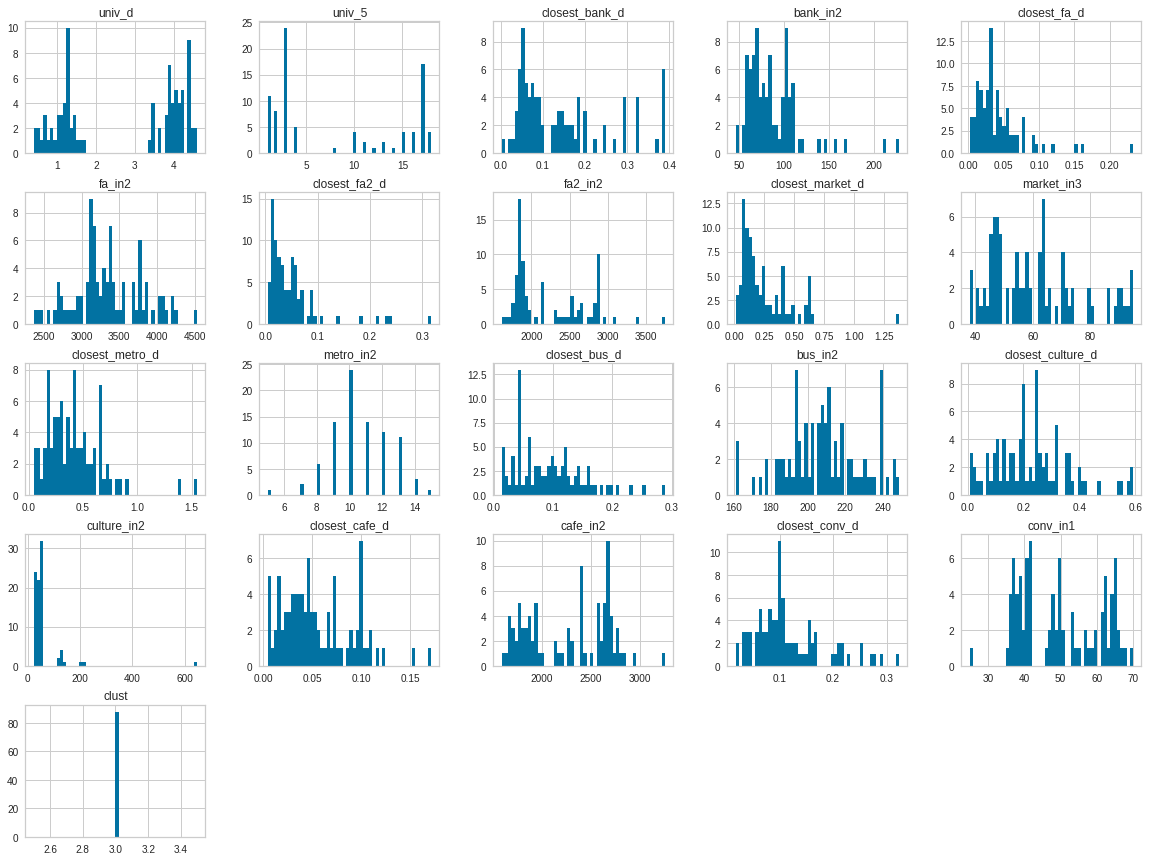

In [ ]:
c3.hist(bins=50, figsize=(20,15))
plt.show()

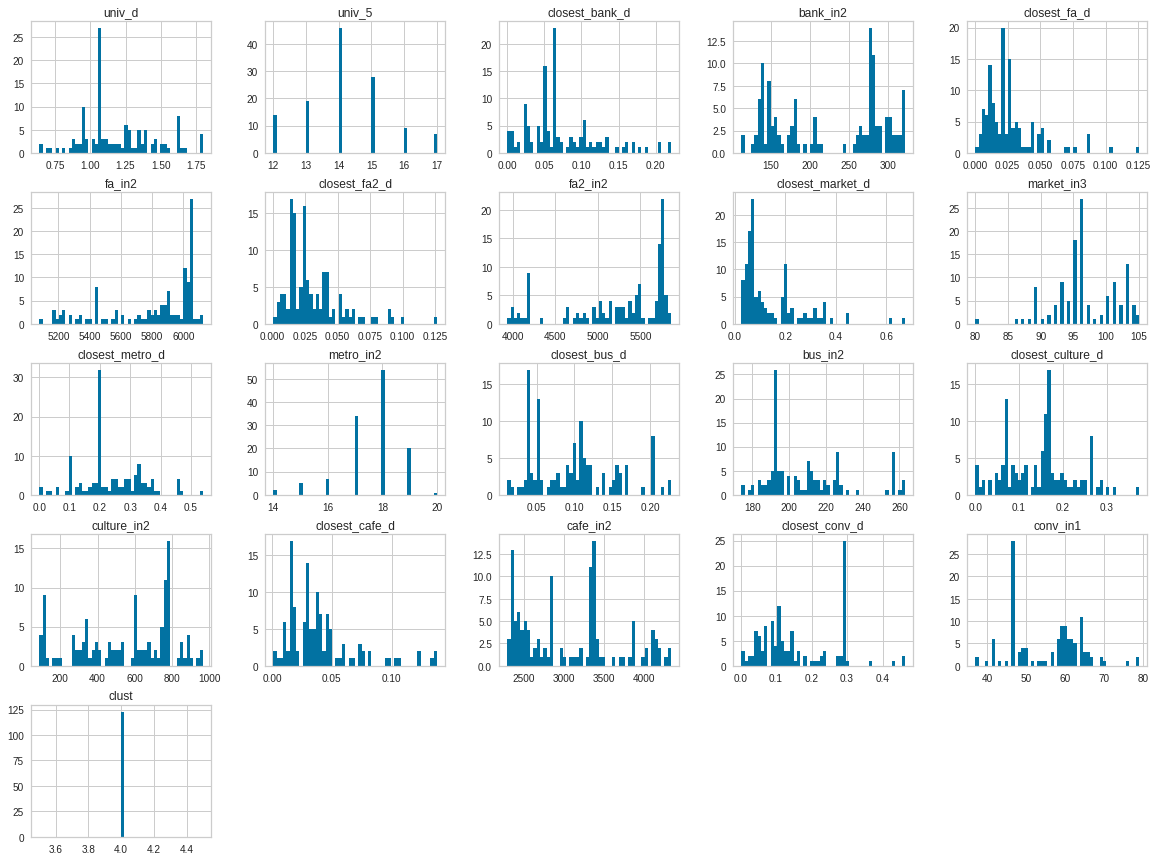

In [ ]:
c4.hist(bins=50, figsize=(20,15))
plt.show()

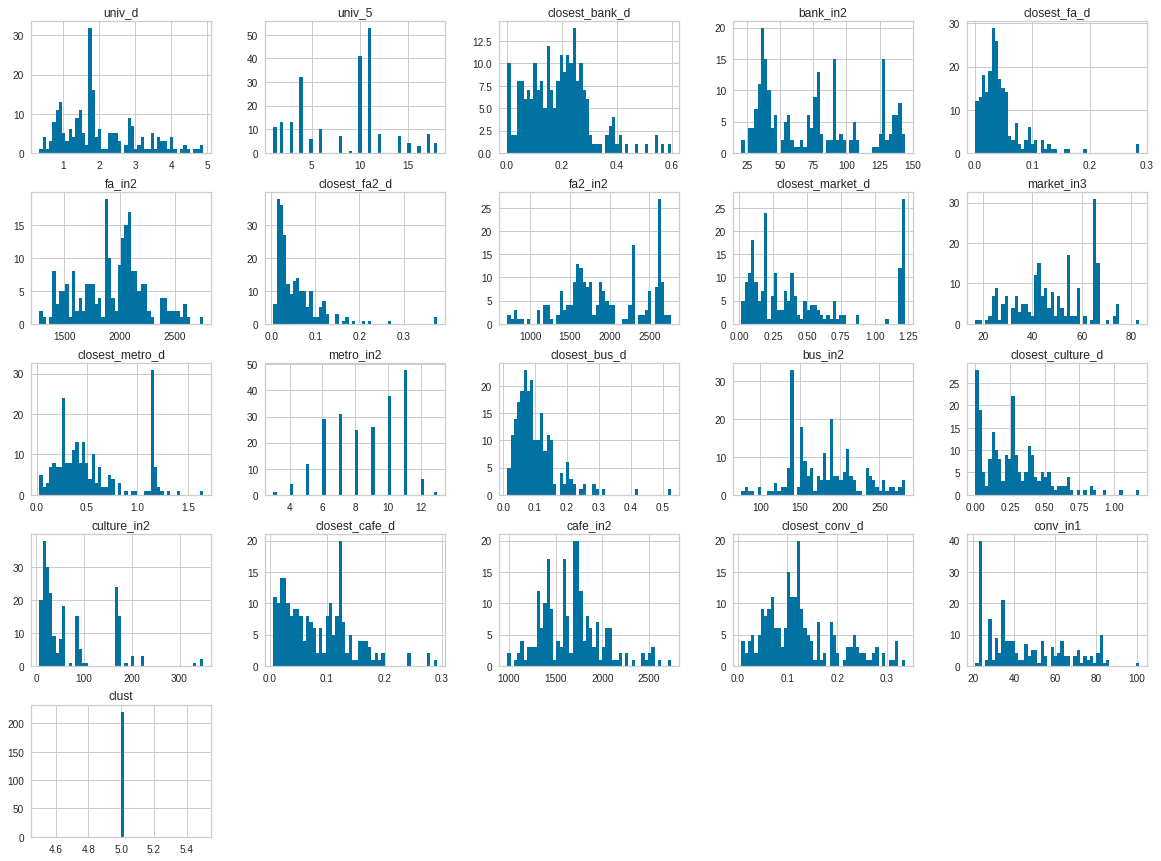

In [ ]:
c5.hist(bins=50, figsize=(20,15))
plt.show()

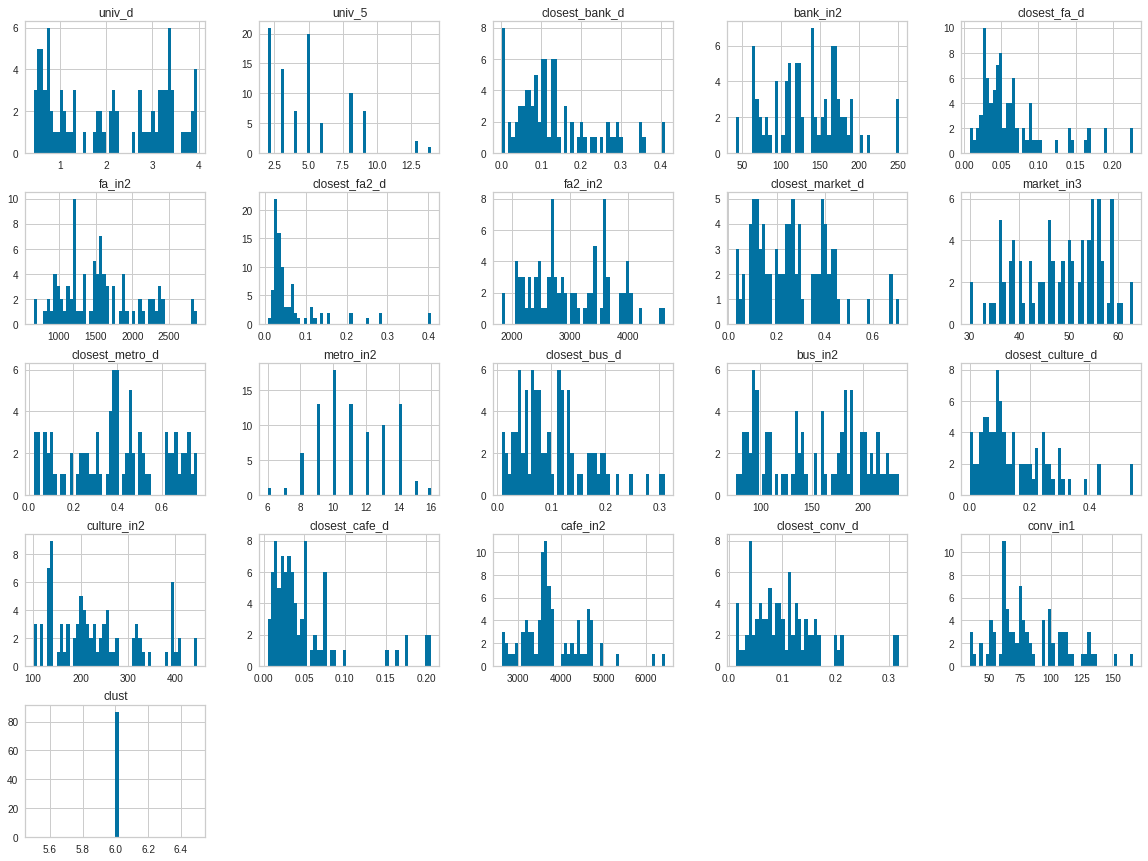

In [ ]:
c6.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
c1.head()

,univ_d,univ_5,closest_bank_d,bank_in2,closest_fa_d,fa_in2,closest_fa2_d,fa2_in2,closest_market_d,market_in3,...,metro_in2,closest_bus_d,bus_in2,closest_culture_d,culture_in2,closest_cafe_d,cafe_in2,closest_conv_d,conv_in1,clust
921,1.927619,15,0.110030,297,0.058143,4922,0.055834,5362,0.111451,76,...,14,0.153422,231,0.143359,722,0.025842,4463,0.139226,76,1
935,0.389469,17,0.147754,125,0.031431,4766,0.034062,4477,0.304746,89,...,13,0.086232,230,0.460776,377,0.022201,2686,0.123209,42,1
936,0.158266,17,0.224002,125,0.122199,4514,0.187624,4432,0.511594,83,...,13,0.059377,232,0.447362,399,0.062187,2602,0.122632,31,1
940,1.815629,13,0.051574,299,0.060850,4743,0.046114,4937,0.119950,73,...,16,0.066289,222,0.139034,624,0.004815,4097,0.063169,98,1
941,1.806244,13,0.053606,300,0.073563,4776,0.065138,4989,0.058975,77,...,16,0.101275,227,0.058732,636,0.002251,4141,0.076005,107,1


In [ ]:
c1.columns

Index(['univ_d', 'univ_5', 'closest_bank_d', 'bank_in2', 'closest_fa_d',
       'fa_in2', 'closest_fa2_d', 'fa2_in2', 'closest_market_d', 'market_in3',
       'closest_metro_d', 'metro_in2', 'closest_bus_d', 'bus_in2',
       'closest_culture_d', 'culture_in2', 'closest_cafe_d', 'cafe_in2',
       'closest_conv_d', 'conv_in1', 'clust'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

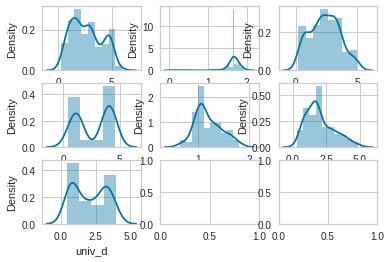

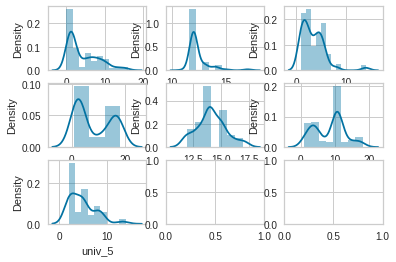

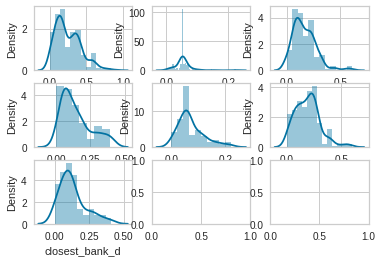

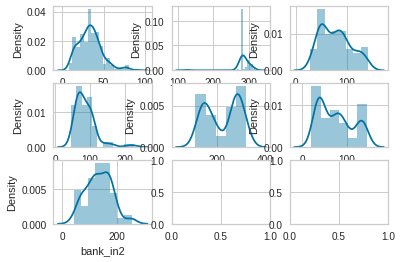

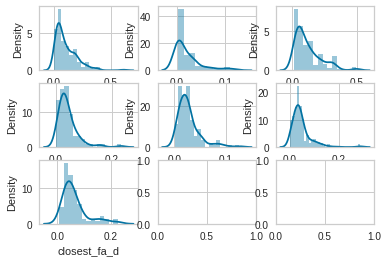

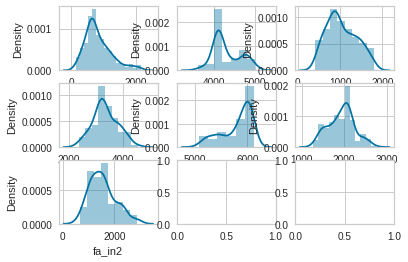

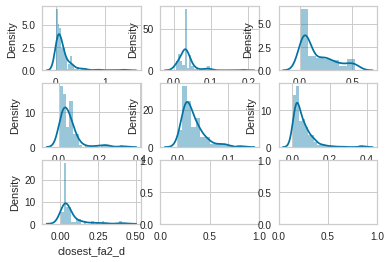

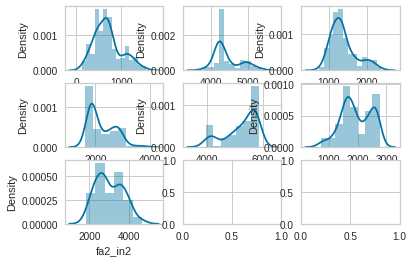

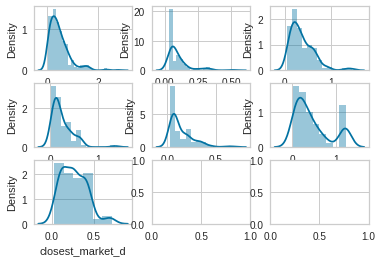

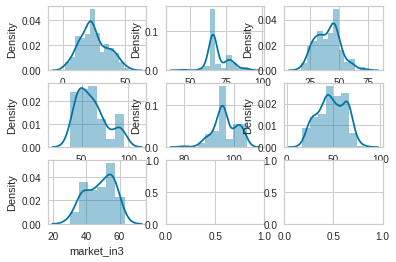

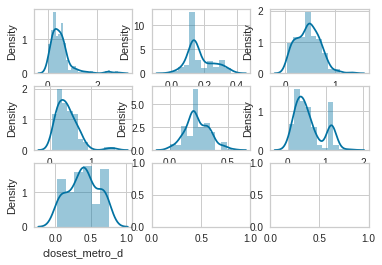

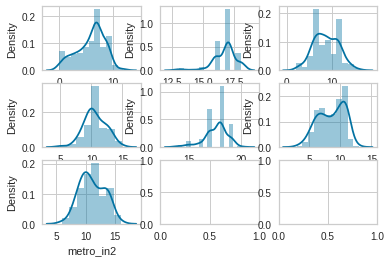

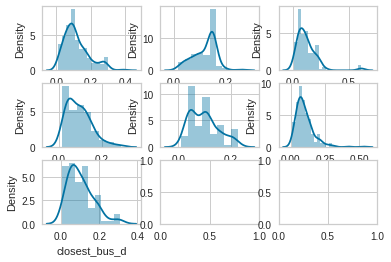

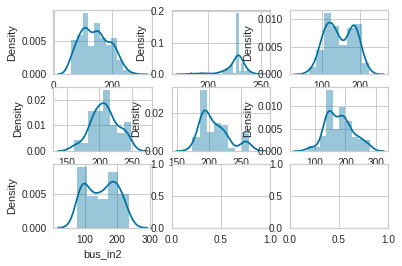

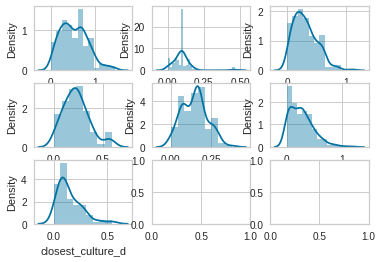

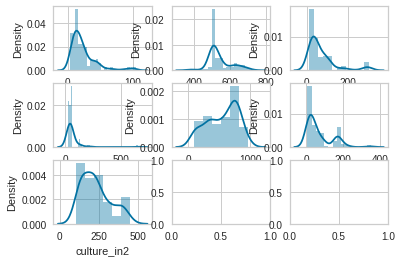

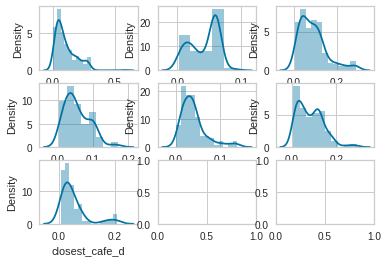

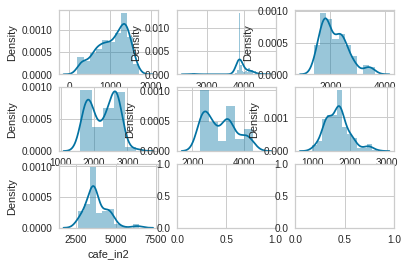

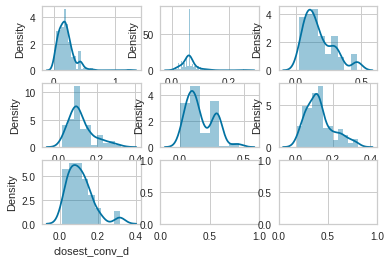

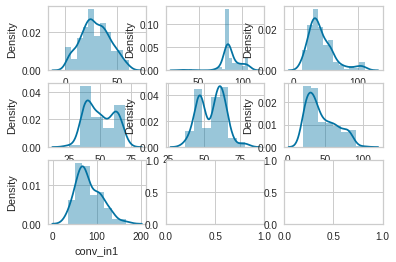

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

col_list=['univ_d', 'univ_5', 'closest_bank_d', 'bank_in2', 'closest_fa_d',
       'fa_in2', 'closest_fa2_d', 'fa2_in2', 'closest_market_d', 'market_in3',
       'closest_metro_d', 'metro_in2', 'closest_bus_d', 'bus_in2',
       'closest_culture_d', 'culture_in2', 'closest_cafe_d', 'cafe_in2',
       'closest_conv_d', 'conv_in1']

for i in col_list:
  fig, ax = plt.subplots(ncols=3, nrows=3)
  sns.distplot(c0[i], ax=ax[0,0])
  sns.distplot(c1[i], ax=ax[0,1])
  sns.distplot(c2[i], ax=ax[0,2])
  sns.distplot(c3[i], ax=ax[1,0])
  sns.distplot(c4[i], ax=ax[1,1])
  sns.distplot(c5[i], ax=ax[1,2])
  sns.distplot(c6[i], ax=ax[2,0])

#입지 점수 계산

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler as mm
from sklearn.preprocessing import StandardScaler as ss

In [ ]:
df=pd.read_csv('/content/drive/Shareddrives/특허데이터분석_BA세션/입지분석/x변수데이터/최종데이터프레임_편의점추가.csv')

In [ ]:
#거리 d
d=df[['univ_d', 'closest_conv_d', 'closest_bank_d', 'closest_fa_d', 'closest_fa2_d', 'closest_market_d',
 'closest_metro_d', 'closest_bus_d', 'closest_culture_d', 'closest_cafe_d']]

In [ ]:
#km이내 개수
k=df[['univ_5','conv_in1','bank_in2','fa_in2','fa2_in2','market_in3','metro_in2', 
       'bus_in2', 'culture_in2','cafe_in2']]

In [ ]:
#거리 데이터 MinMaxScaler
x = d.values
mm_d = mm()
x_scaled = mm_d.fit_transform(x)

d_scores=pd.DataFrame(x_scaled)
d_scores.columns=['univ_d', 'closest_conv_d', 'closest_bank_d', 'closest_fa_d', 'closest_fa2_d', 'closest_market_d',
 'closest_metro_d', 'closest_bus_d', 'closest_culture_d', 'closest_cafe_d']

d_score=d_scores.sum(axis=1)

d_rank=d_score.sort_values().index

In [ ]:
#장소 수 MinMaxScaler
x = k.values
mm_k = mm()
x_scaled = mm_k.fit_transform(x)

k_scores=pd.DataFrame(x_scaled)
k_scores.columns=['univ_5','conv_in1','bank_in2','fa_in2','fa2_in2','market_in3','metro_in2','bus_in2', 'culture_in2','cafe_in2']

#가중치 없이 (모든 변수 동등 고려)
k_score=k_scores.sum(axis=1)

k_rank=k_score.sort_values(key= lambda x: -x).index

(array([136., 326., 275., 225.,  85.,  80.,  35.,  11.,   0.,   4.]),
 array([0.38634932, 0.85369122, 1.32103313, 1.78837504, 2.25571694,
        2.72305885, 3.19040076, 3.65774266, 4.12508457, 4.59242647,
        5.05976838]),
 <a list of 10 Patch objects>)

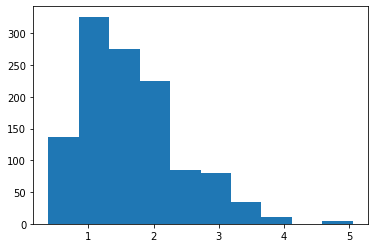

In [ ]:
plt.hist(d_score)

(array([ 54., 147., 254., 231., 198.,  49.,  19.,  24., 120.,  81.]),
 array([0.34418739, 1.10991018, 1.87563297, 2.64135576, 3.40707855,
        4.17280134, 4.93852413, 5.70424693, 6.46996972, 7.23569251,
        8.0014153 ]),
 <a list of 10 Patch objects>)

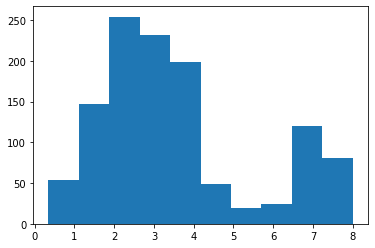

In [ ]:
plt.hist(k_score) 

In [ ]:
df['d_score']=d_score
df['k_score']=k_score

In [ ]:
df_score=df.sort_values(by = ['k_score', 'd_score'], ascending = [False, True])



---



# 스코어링

In [ ]:
x = df.k_score.values
mm_ks = mm()
x_scaled = mm_ks.fit_transform(x.reshape(-1,1))

k=pd.DataFrame(x_scaled)

k_sc_score=k.sum(axis=1)

In [ ]:
x = df.d_score.values
mm_ds = mm()
x_scaled = mm_ds.fit_transform(x.reshape(-1,1))

k=pd.DataFrame(x_scaled)

d_sc_score=k.sum(axis=1)

In [ ]:
df['k_sc_score']=k_sc_score
df['d_sc_score']=d_sc_score

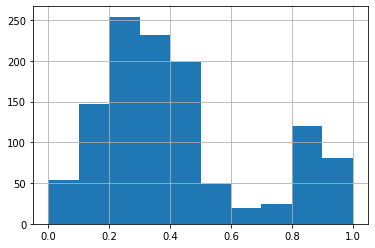

In [ ]:
k_sc_score.hist()

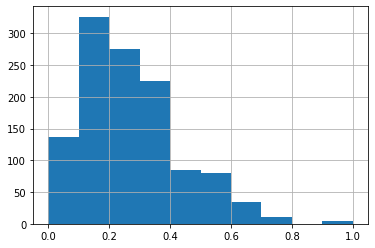

In [ ]:
d_sc_score.hist()

In [ ]:
#k조정점수 , (1- d조정점수)의 평균
df['score']= df.apply(lambda row: (row.k_sc_score+1-row.d_sc_score)/2, axis=1)

In [ ]:
kd_scores=(k_scores.values+(1-d_scores))/2

In [ ]:
kd_scores.columns=[['univ',	'conv',	'bank',	'fa',	'fa2',	'market',	'metro',	'bus',	'culture', 'cafe']]

In [ ]:
#군집분석 라벨 추가
cluster=pd.read_csv('/content/drive/Shareddrives/특허데이터분석_BA세션/입지분석/x변수데이터/클러스터링결과.csv')

In [ ]:
df['clust']=cluster.clust

#필터링 기반 추천 함수 정의

In [ ]:
import folium as g
from folium import Marker, Icon
import requests
import json
import numpy as np

In [ ]:
#등호/부등호 사용한 기준 순위, 군집 라벨, 순위 매김 방식 (0이면 종합 점수 반영 (default), 2면 순위 관련 점수만 반영)
def my_place(want,cluster,rank=0):

  #가중치 
  from collections import defaultdict
  weight=defaultdict(list)
  weight['==']=(1/np.array([1,1,1]))/sum(1/np.array([1,1,1]))
  weight['>=']=(1/np.array([0.6,0.8,0.8]))/sum(1/np.array([0.6,0.8,0.8]))
  weight['=>']=(1/np.array([0.6,0.6,0.8]))/sum(1/np.array([0.6,0.6,0.8]))
  weight['>>']=(1/np.array([0.6,0.7,0.8]))/sum(1/np.array([0.6,0.7,0.8]))

  #입력 내용 저장
  s=0; n=[]; c=''
  for i in range(len(want)):
    if want[i]=='>' or want[i]=='=':
      c+=want[i]; n.append(want[s:i]); s=i+1 #c에 >또는=, n에 기준이름 추가
  n.append(want[s:])

  #정렬 기준1: 가중합 점수--------
  
  w=weight[c]
  #가중치 계산
  weighted_score=kd_scores.apply(lambda row: row[n[0]]*w[0]+row[n[1]]*w[1]+row[n[2]]*w[2], axis=1)
  df['weighted_score']=weighted_score
  #가중치 순위 인덱스
  rank1=weighted_score.argsort()[::-1] #내림차순 정렬
 
  #정렬 기준2: 가중&전체 합산 점수---------
  rank2=np.array(weighted_score+df.score).argsort()[::-1]

  if rank==1: rank=rank1
  else: rank=rank2

  #변수명 매칭

  names=['도로명','좌표','score','weighted_score']

  #기준별 변수 매칭 & 추가
  column=defaultdict(list,{'univ':['univ_d', 'univ_u'],'bank':['closest_bank_d', 'closest_bank', 'bank_in2'],
          'fa':['closest_fa_d','closest_fa', 'fa_in2'],'fa2':['closest_fa2_d', 'closest_fa2', 'fa2_in2'],
          'market':['closest_market_d', 'closest_market', 'market_in3'], 'metro':['closest_metro_d','closest_metro'],
          'bus':['closest_bus_d', 'closest_bus', 'bus_in2'], 'culture':['closest_culture_d', 'closest_culture', 'culture_in2'],
          'cafe':['closest_cafe_d','closest_cafe', 'cafe_in2'], 'conv':['closest_conv_d', 'closest_conv','conv_in1']})
  for c in n:
    names.extend(column[c])

  #상위 100곳
  data=df[names].loc[rank][df['clust']==cluster][:100]
  
  #지도 시각화용 위도, 경도 열 추가
  data[['latitude', 'longitude']] = data['좌표'].str.split(",", n=1, expand=True)
  latitude=[]; longitude=[]
  for x in data.좌표:
    s=x.split(', ')
    latitude.append(float(s[0][1:]))
    longitude.append(float(s[1][:-1]))
  data['latitude']=latitude; data['longitude']=longitude

  #인덱스 초기화
  data.reset_index(inplace=True,drop=True)
  return data

#상위 입지 시각화

In [ ]:
data=my_place('metro>market>conv',4,2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
m = g.Map(location=[37.8, 127], tiles='openstreetmap', zoom_start=10)

In [ ]:
#지도에 시각화
for i in range(len(data)):

  lasta = data['latitude'][i]
  lastb = data['longitude'][i]
  
  if i<25:
      g.Marker([lasta,lastb],popup='showadd',tooltip = "0", icon=g.Icon(color='blue',icon='blue')).add_to(m)
  elif i<50:
      g.Marker([lasta,lastb],popup='showadd',tooltip = "1", icon=g.Icon(color='cadetblue',icon='cadetblue')).add_to(m)
  elif i<75:
      g.Marker([lasta,lastb],popup='showadd',tooltip = "2", icon=g.Icon(color='green',icon='green')).add_to(m)
  else:
      g.Marker([lasta,lastb],popup='showadd',tooltip = "3", icon=g.Icon(color='lightgreen',icon='lightgreen')).add_to(m)


In [ ]:
m